<div style="color:#007acc; text-align:center; font-size:32px; font-weight:bold; font-family:Arial, sans-serif;">
  Explore Data Analysis and Transform Purchase Log Data
</div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns',None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [2]:
df=pd.read_csv("../ingest_from_ITS/data/m952_purchase_2025-05-01_00-00-00_to_2025-06-26_00-00-00.csv") 
df

,@timestamp,user.id,event.its.properties.product_name,event.its.properties.payment_amount
0,2025-05-01T00:00:47.311Z,2407101213288475,PremiumCard,7.88
1,2025-05-01T00:00:48.114Z,2407031054495048,PremiumCard,7.88
2,2025-05-01T00:01:13.716Z,2408252045392366,PremiumCard,8.48
3,2025-05-01T00:01:17.839Z,2504291256453716,100 Silk,3.00
4,2025-05-01T00:01:22.083Z,2504051634480468,com.silkroad.pack.gold,0.99
...,...,...,...,...
97354,2025-06-25T23:51:31.633Z,2505200949170396,500 Diamond,15.00
97355,2025-06-25T23:53:53.844Z,2406171618439883,com.silkroad.pack.100diamond,3.99
97356,2025-06-25T23:55:01.243Z,2503191105447775,100 Silk,3.49
97357,2025-06-25T23:58:42.493Z,2506090230120563,RechargeTable_Name_43,1.99


In [3]:
df['user.id']=df['user.id'].astype(str)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97359 entries, 0 to 97358
Data columns (total 4 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   @timestamp                           97359 non-null  object 
 1   user.id                              97359 non-null  object 
 2   event.its.properties.product_name    97359 non-null  object 
 3   event.its.properties.payment_amount  97359 non-null  float64
dtypes: float64(1), object(3)
memory usage: 3.0+ MB


In [5]:
df.describe()

,event.its.properties.payment_amount
count,97359.00
mean,10.56
std,14.11
min,-99.99
25%,3.99
50%,7.88
75%,15.00
max,360.00


In [6]:
df.isnull().sum()

@timestamp                             0
user.id                                0
event.its.properties.product_name      0
event.its.properties.payment_amount    0
dtype: int64

In [7]:
null_ratio = df.isnull().mean()
cols_to_drop = null_ratio[null_ratio > 0.95].index
print("column deleted:", list(cols_to_drop))
df = df.drop(columns=cols_to_drop)
df.shape

column deleted: []


(97359, 4)

In [8]:
df['@timestamp'] = pd.to_datetime(df['@timestamp'], errors='coerce', utc=True)
df.shape

(97359, 4)

In [9]:
len(df['user.id'].unique())

37259

In [10]:
df['event.its.properties.payment_amount'].sum()

np.float64(1027685.5200000001)

In [11]:
df=df.rename(columns={'user.id':'vopenid'})

#### **Visualize**

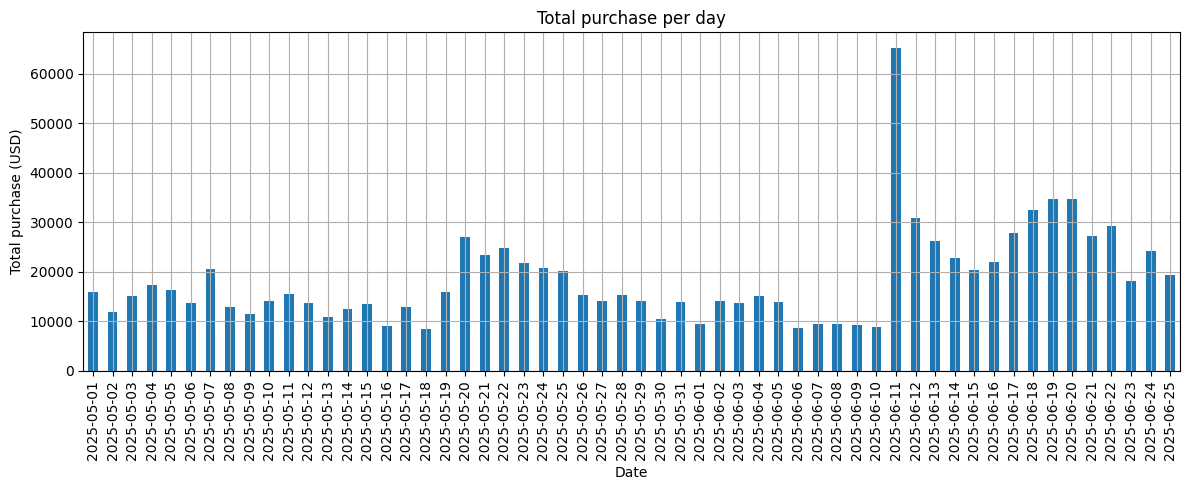

In [12]:
df["@timestamp"] = pd.to_datetime(df["@timestamp"])
df["date"] = df["@timestamp"].dt.date

daily_payment = df.groupby("date")["event.its.properties.payment_amount"].sum()

daily_payment.plot(kind="bar", figsize=(12, 5), title="Total purchase per day")
plt.ylabel("Total purchase (USD)")
plt.xlabel("Date")
plt.grid(True)
plt.tight_layout()
plt.show()

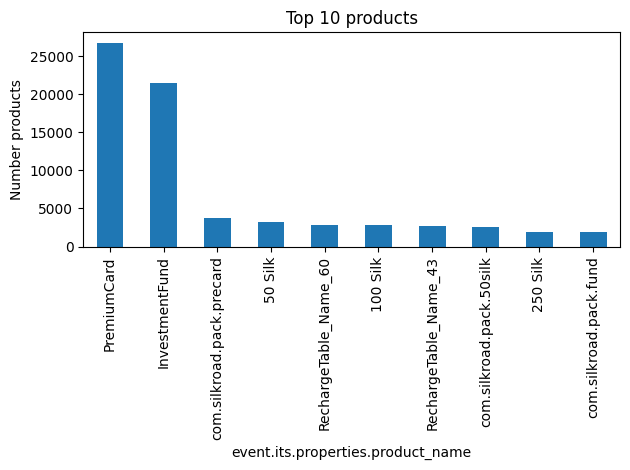

In [13]:
top_products = df["event.its.properties.product_name"].value_counts().head(10)
top_products.plot(kind="bar", title="Top 10 products")
plt.ylabel("Number products")
plt.tight_layout()
plt.show()

#### **Create features**

In [14]:
data=df
# now = pd.Timestamp.now(tz='UTC')
now = pd.Timestamp("2025-06-26 07:00:00", tz="UTC")

In [15]:
def last_update_time(group):
    last_time = group['@timestamp'].max()
    return {
        'last_update_time': last_time
    }

In [16]:
def num_purchase(group):
    count = len(group)
    refund_count = (group['event.its.properties.payment_amount'] < 0).sum()
    count -= refund_count
    return {
        'num_purchase': max(count, 0)  
    }

In [17]:
def total_money_purchase(group):
    total=group['event.its.properties.payment_amount'].sum()
    if total < 0:
        total=0
    return {
        'total_purchase': total
    }

In [18]:
def max_purchase(group):
    max_mount=group['event.its.properties.payment_amount'].max()
    if max_mount < 0:
        max_mount=0
    return {
        'max_purchase':max_mount,
    }

In [19]:
def count_purchase_on_day(group):
    if group.empty:
        return pd.Series({'count_purchase_on_day': 0})

    group['date'] = group['@timestamp'].dt.date
    daily_counts = group.groupby('date').size()

    avg = daily_counts.mean()
    
    return {
        'count_purchase_on_day': avg
    }

In [20]:
def avg_purchase(group):
    total_purchase = group['event.its.properties.payment_amount'].sum()
    num_purchase = len(group)
    return {
        'avg_purchase': total_purchase / num_purchase if num_purchase > 0 else 0
    }

In [21]:
def std_amount_purchase(group):
    amounts = group['event.its.properties.payment_amount']
    amounts = amounts[amounts >= 0]
    
    if len(amounts) < 2:
        std = 0.0  
    else:
        std = amounts.std()
    
    return {
        'std_amount_purchase': std
    }

In [22]:
def frequency_purchase(group):
    num_purchase = len(group)
    days = group['@timestamp'].dt.date.nunique()
    return {
        'frequency_purchase': num_purchase / days if days > 0 else 0
    }

In [23]:
def days_since_last_purchase(group):
    last_time = group['@timestamp'].max()
    return pd.Series({
        'days_since_last_purchase': (now - last_time).days
    })

In [24]:
def num_products(group):
    try:
        unique_products = group['event.its.properties.product_name'].nunique()
        return {
            'num_product_buyed': unique_products
        }
    except Exception as e:
        print(f"Error in num_products: {e}")
        return {
            'num_product_buyed': 0
        }

In [25]:
features_function=[
   last_update_time,
   total_money_purchase,
   num_purchase,
   max_purchase,
   avg_purchase,
   frequency_purchase,
   count_purchase_on_day,
   std_amount_purchase,
   days_since_last_purchase,
   num_products,
]

In [26]:
def extract_group_features(group):
    result={}
    for func in features_function:
        try:
            result.update(func(group))
        except Exception as e:
            print(f"Error at feature: {func}. Error: {e}")
    return pd.Series(result)

df_res = data.groupby('vopenid').apply(extract_group_features).reset_index()
df_res

C:\Users\GOSU.GOSU-TT-ZION1\AppData\Local\Temp\ipykernel_19080\3747869921.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_res = data.groupby('vopenid').apply(extract_group_features).reset_index()


,vopenid,last_update_time,total_purchase,num_purchase,max_purchase,avg_purchase,frequency_purchase,count_purchase_on_day,std_amount_purchase,days_since_last_purchase,num_product_buyed
0,2206151945395710,2025-06-24 22:46:22.711000+00:00,3.99,1,3.99,3.99,1.00,1.00,0.00,1,1
1,2206211830166192,2025-05-24 15:48:36.757000+00:00,0.79,1,0.79,0.79,1.00,1.00,0.00,32,1
2,2208132058338497,2025-06-20 03:06:03.875000+00:00,1.99,1,1.99,1.99,1.00,1.00,0.00,6,1
3,2210221534402190,2025-05-26 05:14:28.541000+00:00,7.88,1,7.88,7.88,1.00,1.00,0.00,31,1
4,2210221828089318,2025-06-11 14:06:52.646000+00:00,3.98,2,1.99,1.99,2.00,2.00,0.00,14,2
...,...,...,...,...,...,...,...,...,...,...,...
37254,6210001017824,2025-06-25 03:01:13.202000+00:00,17.79,5,7.88,3.56,1.25,1.25,2.56,1,3
37255,6210001048809,2025-05-02 05:53:07.510000+00:00,1.99,1,1.99,1.99,1.00,1.00,0.00,55,1
37256,6210001076576,2025-05-05 18:33:57.853000+00:00,1.58,1,1.58,1.58,1.00,1.00,0.00,51,1
37257,6220001331202,2025-06-12 14:39:00.448000+00:00,1.99,1,1.99,1.99,1.00,1.00,0.00,13,1


In [27]:
df_res = df_res[~(df_res['total_purchase'] == 0)]

In [28]:
df_res.to_csv("data/purchase_transform.csv",index=False,header=True)

In [29]:
df_res['std_amount_purchase'].min(),df_res['std_amount_purchase'].max()

(np.float64(0.0), np.float64(196.22980949217003))

In [30]:
df_res['total_purchase'].sum()

np.float64(1028083.63)

In [31]:
df_res[df_res['days_since_last_purchase']<0]

,vopenid,last_update_time,total_purchase,num_purchase,max_purchase,avg_purchase,frequency_purchase,count_purchase_on_day,std_amount_purchase,days_since_last_purchase,num_product_buyed
